# MMIK - lab 11: Measurement error mitigation

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
import qiskit 
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

### Obwód - algorytm Grovera dla szukanego |00>

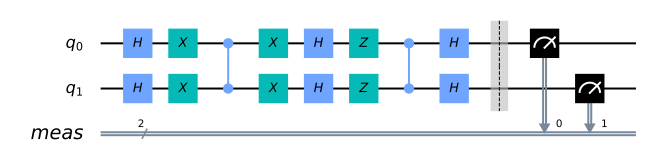

In [17]:
n = 2
grover_circuit = QuantumCircuit(n)

for qubit in range(n):
    grover_circuit.h(qubit)

for qubit in range(n):
    grover_circuit.x(qubit)

grover_circuit.cz(0, 1)

for qubit in range(n):
    grover_circuit.x(qubit)

for qubit in range(n):
    grover_circuit.h(qubit)

for qubit in range(n):
    grover_circuit.z(qubit)

grover_circuit.cz(0, 1)

for qubit in range(n):
    grover_circuit.h(qubit)

grover_circuit.measure_all()

grover_circuit.draw('mpl')

In [18]:
# wybór komputera
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_burlington')

ibmqfactory.load_account:WARNING:2020-06-06 12:47:34,306: Credentials are already in use. The existing account in the session will be replaced.


### Obliczenie macierzy kalibracji
Przeprowadzamy eksperymenty pomiaru różnych wartości na tym komputerze tworząc stosowne obwody (|00>, |01>, |10>, |11>) i sprawdzamy z jakim prawdopodobieństwiem doszło do pomyłki.

In [19]:
qr = qiskit.QuantumRegister(2)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0, 1], qr=qr, circlabel='mcal')

In [20]:
job = qiskit.execute(meas_calibs, backend=backend, shots=1024)
cal_results = job.result()

[[0.87402344 0.16308594 0.16699219 0.03515625]
 [0.02929688 0.75292969 0.0234375  0.14355469]
 [0.03417969 0.01269531 0.74707031 0.12792969]
 [0.0625     0.07128906 0.0625     0.69335938]]


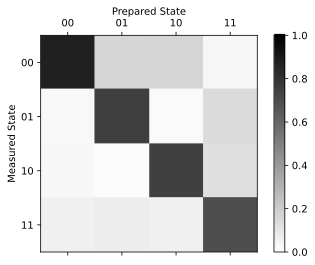

In [21]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=[0, 1], circlabel='mcal')
print(meas_fitter.cal_matrix)
meas_fitter.plot_calibration()

### Eksperyment z zastosowaniem mitygacji

In [22]:
job = qiskit.execute(grover_circuit, backend=backend, shots=1024)
results = job.result()

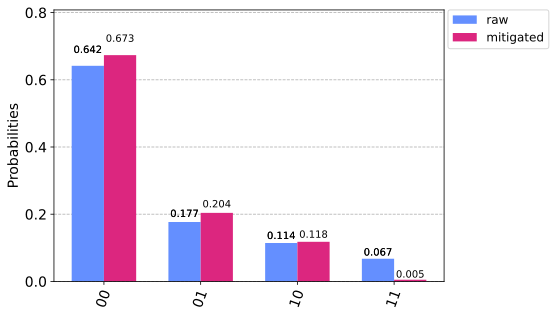

In [23]:
# Results without mitigation
raw_counts = results.get_counts()

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_results = meas_filter.apply(results)
mitigated_counts = mitigated_results.get_counts(0)

from qiskit.tools.visualization import *
plot_histogram([raw_counts, mitigated_counts], legend=['raw', 'mitigated'])

Jak widać udało się nieznacznie poprawić wynik dla oczekiwanego rezultatu |00>. Stało się tak dlatego, że poznaliśmy charakterystykę obwodu w postaci macierzy mitygacji M podczas mierzenia różnych wyników. Ponieważ C_noisy = M * C_ideal, to poprawiony wynik C_ideal = M^(-1) * C_noisy.